<a href="https://colab.research.google.com/github/bitanb1999/NLP_Univ_Project/blob/main/Abstractive_Summarisation_with_Word2Vec_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Abstractive Summarisation using seq2seq LSTM with attention and word2vec embeddings:**

In the previous notebooks we have have explained what is seq2seq model and what is LSTM. In this notebook we are using pretrained word2vec embeddings in the embedding layer.

### **What are word2vec embeddings?**
The word2vec embeddings are a 300 length vector for each word. They were trained on a huge corpus of text data by google. They capture the meaning of the words in such a way that words which are similar in meaning lie close to each other in the 300 dimensional vector space and hence have high cosine similarity. 


### **Why we use word2vec embeddings?**
The word2vec embedding is highly trained on huge text dataset. It hence learns association between words. Many such associations are learnt after rigorous training mostly on high-end machines and precisely calculated parameters. We take the advantage of these learned associations by keeping the embedding layer untrainable. Additional training in the context of our task, may result in unusual behaviour of the Embedding layer and also distort the learned associations.

Following figure illustrates an example of converting words to fixed dimension word embedding:

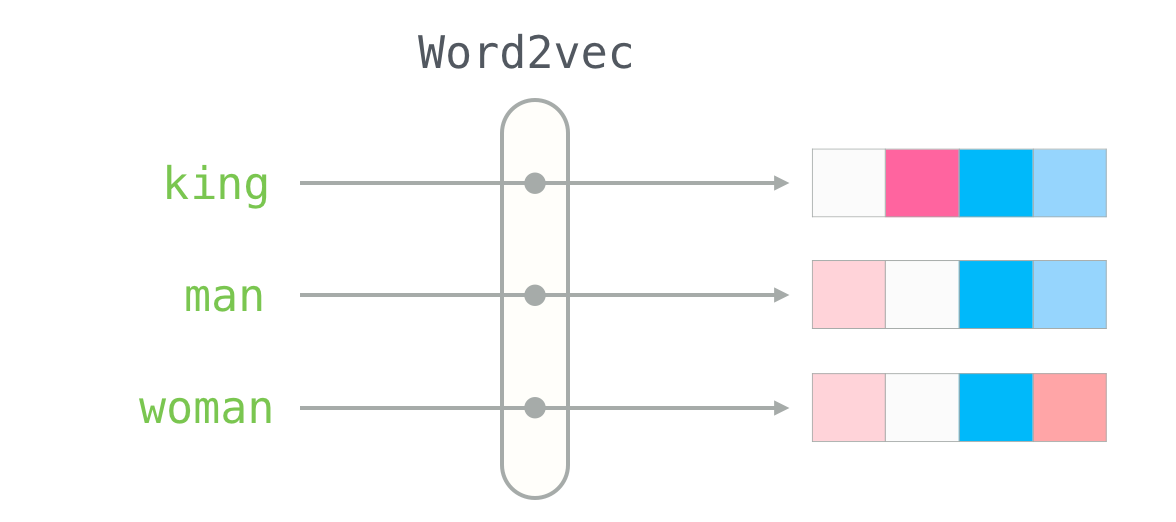

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense,Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df=pd.read_csv("/home/wikihowAll.csv")[:4000]

In [ ]:
unique_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
#clean data using helper code
import re
def transform(summary):
    # Lower case
    summary = summary.lower()
    summary=summary.replace('\n',' ')
    # Remove HTML
    summary = re.sub('<br /><br />', ' ', summary)
       
    # Replace all non-alphanumeric characters with spaces
    summary = re.sub(r'[^a-zA-Z0-9\s]', '', summary)
    # removing contractions
    summary=' '.join([unique_mapping[t] if t in unique_mapping else t for t in summary.split(" ")]) 
    
    return summary

In [ ]:
df['headline']=df['headline'].apply(lambda x:transform(str(x)))
df['text']=df['text'].apply(lambda x:transform(str(x)))

In [ ]:
#we consider only the headline and text
df=df[['headline','text']]

In [ ]:
df['headline']=df['headline'].apply(lambda x: 'sostok '+str(x)+' eostok')

In [ ]:
#truncating to 63rd percentile
max_length=509
max_len_headlines=128

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['text'],df['headline'],test_size=0.2,random_state=1,shuffle=True)

In [ ]:
#Find the percentage of occurrence of rare words in the text.
thresh = 5

count = 0
tot_count = 0
x_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=tot_count,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=True,
)
x_tokenizer.fit_on_texts(list(x_tr))

for key, value in x_tokenizer.word_counts.items():
    tot_count = tot_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary: ", (count / tot_count) * 100)

% of rare words in vocabulary:  71.39382694381065


In [ ]:
tot_count

39883

In [ ]:
# # Prepare a tokenizer
x_tokenizer=tf.keras.preprocessing.text.Tokenizer(
    num_words=tot_count,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=True,
)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = tf.keras.preprocessing.sequence.pad_sequences(x_tr_seq,  maxlen=max_length, padding='post')
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val_seq, maxlen=max_length, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 39884


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

count = 0
tot_count = 0

for key, value in y_tokenizer.word_counts.items():
    tot_count = tot_count + 1
    if value < thresh:
        count = count + 1
    
print("% of rare words in vocabulary:",(count / tot_count) * 100)

# Prepare a tokenizer
y_tokenizer = Tokenizer(num_words=tot_count) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = tf.keras.preprocessing.sequence.pad_sequences(y_tr_seq, maxlen=max_len_headlines, padding='post')
y_val = tf.keras.preprocessing.sequence.pad_sequences(y_val_seq, maxlen=max_len_headlines, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 71.404821280133
Size of vocabulary in Y = 10828


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    count = 0
    for j in y_tr[i]:
        if j != 0:
            count = count + 1
    if count == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
!pip install gensim

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
# load the word2vec vectors
import gensim
import gensim.downloader as api
word_vectors = api.load("word2vec-google-news-300")

In [ ]:
len(x_tokenizer.word_index)

39884

In [ ]:
len(y_tokenizer.word_index)

10827

In [ ]:
x_inv_index = { j:i for i,j in x_tokenizer.word_index.items()}
y_inv_index = { j:i for i,j in y_tokenizer.word_index.items()}

In [ ]:
# 0th element will be a random 300 len array for <s> token
# magnitude of rest of the word_vectors is around 2 to 3 so restricting low and high allows to keep magnitude of random vector in that range
pad_vector = np.random.uniform(low=-0.3, high=0.3, size=(300,))
# 1st element will be a random 300 len array for <s> token
start_vector = np.random.uniform(low=-0.3, high=0.3, size=(300,))
# 2nd element will be a random 300 len array for unknown token
unknown_vector = np.random.uniform(low=-0.3, high=0.3, size=(300,))
# 3rd element will be a random 300 len array for </s> token
end_vector = np.random.uniform(low=-0.3, high=0.3, size=(300,))

In [ ]:
# words which are not in word2vec emb will be omitted from the x and y sequences
x_to_omit = []
x_emb = [pad_vector,pad_vector] # for some reason x_tokenizer.word_index has bool True at 1 so ignore it

for i in range(2, len(x_tokenizer.word_index)):
    if x_inv_index[i] in word_vectors:
        x_emb.append(word_vectors[x_inv_index[i]])
    else:
        x_to_omit.append(i)
        x_emb.append(pad_vector)

In [ ]:
# words which are not in word2vec emb will be omitted from the x and y sequences
y_to_omit = []
y_emb = [pad_vector]

for i in range(1, len(y_tokenizer.word_index)+1):
    if y_inv_index[i] == 'eostok':
        y_emb.append(end_vector)
    elif y_inv_index[i] == 'sostok':
        y_emb.append(start_vector)
    elif y_inv_index[i] in word_vectors:
        y_emb.append(word_vectors[y_inv_index[i]])
    else:
        y_to_omit.append(i)
        y_emb.append(pad_vector)

In [ ]:
print(len(x_emb), len(y_emb))

39884 10828


In [ ]:
x_emb = np.array(x_emb)
y_emb = np.array(y_emb)

In [ ]:
print(x_emb.shape, y_emb.shape)

(39884, 300) (10828, 300)


In [ ]:
# replace the tokens to omit since we mask them
def replace_tokens_to_omit(x_curr, to_omit, max_len):
    to_omit = set(to_omit)
    x_new = []
    for x in x_curr:
        x_n = []
        for x_ in x:
            if x_ == 0:
                continue # since it's all padding after the first 0
            if x_ in to_omit:
                x_n.append(0) # since we mask the padding
            else:
                x_n.append(x_)
        x_n = x_n + [0]*(max_len-len(x_n))
        x_new.append(np.array(x_n))
    return np.array(x_new)

x_tr_new = replace_tokens_to_omit(x_tr,x_to_omit,max_length)
x_val_new = replace_tokens_to_omit(x_val,x_to_omit,max_length)
y_tr_new = replace_tokens_to_omit(y_tr,y_to_omit,max_len_headlines)
y_val_new = replace_tokens_to_omit(y_val,y_to_omit,max_len_headlines)

In [ ]:
print(x_tr.shape, x_tr_new.shape, x_val.shape, x_val_new.shape)
print(y_tr.shape, y_tr_new.shape, y_val.shape, y_val_new.shape)

(3200, 509) (3200, 509) (800, 509) (800, 509)
(3200, 128) (3200, 128) (800, 128) (800, 128)


In [ ]:
x_tr = x_tr_new
x_val = x_val_new
y_tr = y_tr_new
y_val = y_val_new

In [ ]:
# free up some space
del word_vectors

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=300

# Encoder
encoder_inputs = Input(shape=(max_length,))

#embedding layer
encoder_emb =  Embedding(x_voc, embedding_dim, mask_zero=True, trainable=False, weights = [x_emb])(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Setting up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_emb_layer = Embedding(y_voc, embedding_dim, mask_zero=True, trainable=False, weights = [y_emb])
decoder_emb = decoder_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

2022-07-29 13:14:38.830578: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-29 13:14:39.292977: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46481 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3d:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 509)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 509, 300)     11965200    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 509, 200),   400800      ['embedding[0][0]']              
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=100,
    callbacks=[es],
    batch_size=256,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/100


2022-07-29 13:14:56.417348: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


13/13 [==============================] - 115s 8s/step - loss: 2.6852 - val_loss: 2.0767
Epoch 2/100
13/13 [==============================] - 102s 8s/step - loss: 2.2450 - val_loss: 2.0590
Epoch 3/100
13/13 [==============================] - 103s 8s/step - loss: 2.2361 - val_loss: 2.0536
Epoch 4/100
13/13 [==============================] - 103s 8s/step - loss: 2.2302 - val_loss: 2.0503
Epoch 5/100
13/13 [==============================] - 103s 8s/step - loss: 2.2227 - val_loss: 2.0435
Epoch 6/100
13/13 [==============================] - 102s 8s/step - loss: 2.2125 - val_loss: 2.0332
Epoch 7/100
13/13 [==============================] - 102s 8s/step - loss: 2.2022 - val_loss: 2.0237
Epoch 8/100
13/13 [==============================] - 101s 8s/step - loss: 2.1913 - val_loss: 2.0170
Epoch 9/100
13/13 [==============================] - 103s 8s/step - loss: 2.1804 - val_loss: 2.0029
Epoch 10/100
13/13 [==============================] - 102s 8s/step - loss: 2.1687 - val_loss: 1.9926
Epoch 11/10

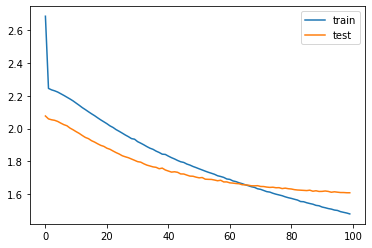

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model.save("lstm_attention_word2vec.h5")

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models for understanding our outputs where the prediction takes place using the context vector

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_length,latent_dim))

# Get the embeddings of the decoder sequence
decoder_emb2= decoder_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def intepreting_sequence(input_seq):

    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        if not sampled_token_index == 0:
            sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or sampled_token_index == 0  or len(decoded_sentence.split()) >= (max_len_headlines-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# To summarise
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# for sequences to texts
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
seqtxt=[]
seqsum=[]
predsum=[]
for i in range(0,3):
    print ('Review:', seq2text(x_tr[i]))
    seqtxt.append(seq2text(x_tr[i]).split(" "))
    print ('\n')
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('\n')
    seqsum.append(seq2summary(y_tr[i]).split(" "))
    predicted=intepreting_sequence(x_tr[i].reshape(1,max_length))
    print ('Predicted summary:',predicted)
    predsum.append(predicted)
    print ('\n')

Review: because this it is recommended increase your intake vitamin c while you are dealing with from taking vitamin c supplement you can also eat fruits that have high amounts vitamin c these include grapefruit kiwi strawberries lemon lime blackberries oranges papaya pineapple pomelo vegetables that are rich in vitamin c these include sprouts broccoli onions garlic red green peppers tomatoes radishes you can also consider making vegetable soup if you dont like eating raw veggies if you have ever wondered why people always give their kids chicken noodle soup when they are sick its because chicken soup is wonder when it comes recovering from virus not only does chicken soup act as an antiinflammatory it also temporarily helps relieve congestion by unblocking your nasal can also add onions garlic other veggies your soup boost its vitamin mineral count zinc governs enzymes in our body that activate different parts our immune system that fight against infection most people choose take mg z

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
scores=0
for i in range(len(predsum)):
    reference = [predsum[i].split(" ")]
    candidate = seqsum[i]
    scores+= sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
print(scores/i)

0.13135402609086821


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
scores=[]
for i in range(len(predsum)):
    reference = predsum[i]
    candidate = ' '.join(seqsum[i])
    print(scorer.score(reference,candidate)['rouge1'])
    scores.append(scorer.score(reference,candidate)['rouge1'])
#print(scores/i)

Score(precision=0.05405405405405406, recall=1.0, fmeasure=0.10256410256410257)
Score(precision=0.09090909090909091, recall=0.5, fmeasure=0.15384615384615385)
Score(precision=0.008620689655172414, recall=0.25, fmeasure=0.016666666666666666)


In [ ]:
np.mean([i[2] for i in scores])

0.09102564102564104